In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import geopandas as gpd
import matplotlib as plt
from shapely.geometry import Point, Polygon
from sklearn.cluster import DBSCAN
from shapely.ops import unary_union
import plotly.graph_objects as go
from shapely.geometry import MultiPoint, box
from plotly.subplots import make_subplots
from datetime import datetime
import seaborn as sns

In [12]:
df1 = pd.read_csv('./data/fire_archive_SV-C2_409232.csv')
df1['acq_date'] = pd.to_datetime(df1['acq_date'])
df1 = df1.sort_values(by=['acq_date', 'acq_time'], ascending=True)
df1.tail()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,type
260108,-27.415340,-70.260925,321.83,0.41,0.45,2022-08-31,518,N,VIIRS,n,1,282.26,1.44,N,2
260109,-36.182384,-70.924660,342.30,0.40,0.60,2022-08-31,1742,N,VIIRS,n,1,292.75,4.40,D,0
260110,-36.180378,-70.924461,330.96,0.40,0.60,2022-08-31,1742,N,VIIRS,n,1,294.31,4.41,D,0
260111,-22.317188,-68.883453,332.83,0.43,0.46,2022-08-31,1748,N,VIIRS,l,1,306.78,4.92,D,2
260112,-18.646139,-69.553741,335.64,0.43,0.46,2022-08-31,1748,N,VIIRS,n,1,306.21,0.65,D,0


In [13]:
df2 = pd.read_csv('./data/fire_nrt_SV-C2_409232.csv')
df2['acq_date'] = pd.to_datetime(df2['acq_date'])
df2 = df2.sort_values(by=['acq_date', 'acq_time'], ascending=True)
df2.tail()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight
63419,-27.05665,-69.91125,351.59,0.43,0.38,2023-12-11,1834,N,VIIRS,l,2.0NRT,327.11,3.53,D
63420,-27.05593,-69.90696,367.00,0.43,0.38,2023-12-11,1834,N,VIIRS,l,2.0NRT,326.54,3.53,D
63421,-25.51162,-70.16331,348.46,0.43,0.38,2023-12-11,1834,N,VIIRS,l,2.0NRT,322.46,2.74,D
63422,-25.50885,-70.16836,349.28,0.43,0.38,2023-12-11,1834,N,VIIRS,l,2.0NRT,321.32,2.74,D
63423,-25.50462,-70.16486,349.44,0.43,0.38,2023-12-11,1834,N,VIIRS,l,2.0NRT,321.80,2.21,D


In [14]:
max_date_a = df1['acq_date'].max()
max_date_b = df2['acq_date'].min()
max_date_a, max_date_b

(Timestamp('2022-08-31 00:00:00'), Timestamp('2022-09-01 00:00:00'))

In [15]:
df1.drop(columns=['type'], inplace=True)
merged_df = pd.concat([df1, df2], axis=0)
merged_df.tail()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight
63419,-27.05665,-69.91125,351.59,0.43,0.38,2023-12-11,1834,N,VIIRS,l,2.0NRT,327.11,3.53,D
63420,-27.05593,-69.90696,367.00,0.43,0.38,2023-12-11,1834,N,VIIRS,l,2.0NRT,326.54,3.53,D
63421,-25.51162,-70.16331,348.46,0.43,0.38,2023-12-11,1834,N,VIIRS,l,2.0NRT,322.46,2.74,D
63422,-25.50885,-70.16836,349.28,0.43,0.38,2023-12-11,1834,N,VIIRS,l,2.0NRT,321.32,2.74,D
63423,-25.50462,-70.16486,349.44,0.43,0.38,2023-12-11,1834,N,VIIRS,l,2.0NRT,321.80,2.21,D


In [16]:
def parse_time(value):
    hours = value // 100
    minutes = value % 100
    return pd.to_timedelta(f"{hours} hours {minutes} minutes")

In [17]:
merged_df['hour'] = merged_df['acq_time'].apply(parse_time)
merged_df['hour'] = merged_df['hour'].dt.components.hours
merged_df.tail()

,latitude,longitude,brightness,scan,track,acq_date,acq_time,satellite,instrument,confidence,version,bright_t31,frp,daynight,hour
63419,-27.05665,-69.91125,351.59,0.43,0.38,2023-12-11,1834,N,VIIRS,l,2.0NRT,327.11,3.53,D,18
63420,-27.05593,-69.90696,367.00,0.43,0.38,2023-12-11,1834,N,VIIRS,l,2.0NRT,326.54,3.53,D,18
63421,-25.51162,-70.16331,348.46,0.43,0.38,2023-12-11,1834,N,VIIRS,l,2.0NRT,322.46,2.74,D,18
63422,-25.50885,-70.16836,349.28,0.43,0.38,2023-12-11,1834,N,VIIRS,l,2.0NRT,321.32,2.74,D,18
63423,-25.50462,-70.16486,349.44,0.43,0.38,2023-12-11,1834,N,VIIRS,l,2.0NRT,321.80,2.21,D,18


<AxesSubplot: xlabel='acq_date'>

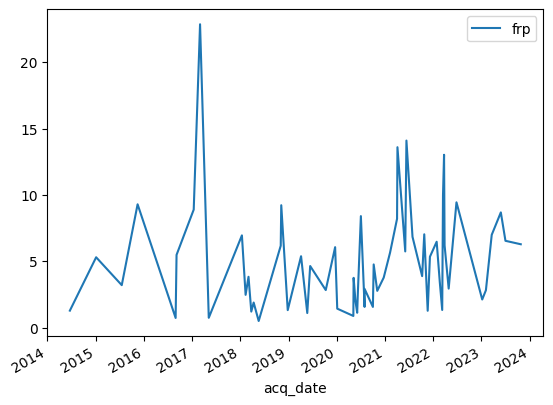

In [22]:
merged_df[merged_df.duplicated(['latitude', 'longitude']) == True].plot(x='acq_date', y='frp')

In [35]:
# Drop not used columns
merged_df.drop(columns=['bright_t31', 'satellite', 'instrument', 'version', 'brightness'], inplace=True)

In [77]:
merged_df.tail()

,latitude,longitude,scan,track,acq_date,acq_time,confidence,frp,daynight,hour
63419,-27.05665,-69.91125,0.43,0.38,2023-12-11,1834,l,3.53,D,18
63420,-27.05593,-69.90696,0.43,0.38,2023-12-11,1834,l,3.53,D,18
63421,-25.51162,-70.16331,0.43,0.38,2023-12-11,1834,l,2.74,D,18
63422,-25.50885,-70.16836,0.43,0.38,2023-12-11,1834,l,2.74,D,18
63423,-25.50462,-70.16486,0.43,0.38,2023-12-11,1834,l,2.21,D,18


In [78]:
merged_df.to_parquet('./db/fires.parquet', index=None)

In [75]:
df = pd.read_parquet('./db/fires.parquet')

In [76]:
df

,latitude,longitude,scan,track,acq_date,acq_time,confidence,frp,daynight,hour
0,-23.362709,-67.729622,0.54,0.42,2013-12-12,518,n,2.52,N,5
1,-23.363398,-67.732323,0.54,0.42,2013-12-12,518,n,2.57,N,5
2,-23.779940,-70.316292,0.49,0.49,2013-12-12,524,n,1.40,N,5
3,-23.784391,-70.317360,0.49,0.49,2013-12-12,524,n,1.14,N,5
4,-23.822016,-70.315941,0.49,0.49,2013-12-12,524,n,1.61,N,5
...,...,...,...,...,...,...,...,...,...,...
270352,-31.760480,-70.970990,0.52,0.42,2023-01-08,1851,n,3.75,D,18
270353,-31.612340,-71.144000,0.52,0.41,2023-01-08,1851,n,2.99,D,18
270354,-30.571540,-71.240360,0.53,0.42,2023-01-08,1851,l,2.44,D,18
270355,-22.315160,-68.880810,0.35,0.57,2023-01-08,1853,n,8.74,D,18


In [74]:
merged_df[merged_df['acq_date'] < '2023-01-01'].to_parquet('./db/fires.parquet', index=None)

In [46]:
dfnew = pd.read_parquet('./db/fires.parquet')

<AxesSubplot: xlabel='acq_date'>

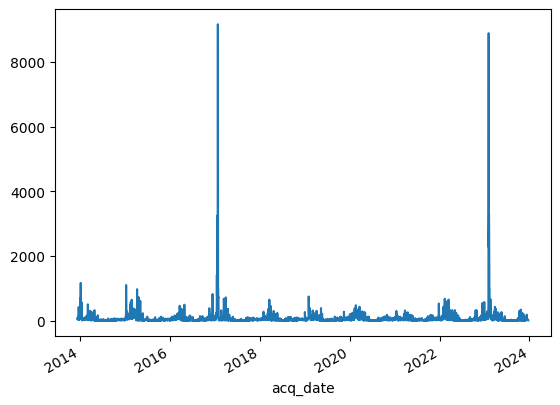

In [59]:
datapoints_per_day = dfnew.groupby('acq_date')['acq_time'].count()
datapoints_per_day.plot()

In [62]:
datapoints_per_day[datapoints_per_day > 1000]

acq_date
2014-01-08    1177
2015-01-12    1111
2017-01-18    1424
2017-01-20    1861
2017-01-21    3257
2017-01-22    2742
2017-01-23    1850
2017-01-24    1677
2017-01-25    3539
2017-01-26    9163
2017-01-27    3120
2017-01-28    1127
2023-02-03    5387
2023-02-04    8887
2023-02-05    2279
2023-02-06    3189
2023-02-07    3297
2023-02-08    2669
2023-02-09    1320
2023-02-10    1028
2023-02-11    1005
Name: acq_time, dtype: int64

<AxesSubplot: xlabel='acq_date'>

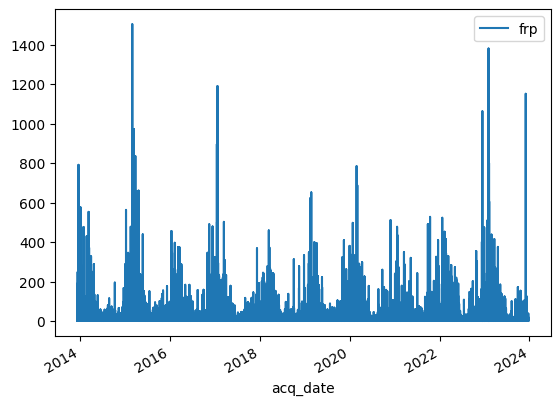

In [51]:
dfnew.plot(x='acq_date', y='frp')

In [2]:
df = pd.read_parquet('../api/db/fires.parquet')
df

,latitude,longitude,scan,track,acq_date,acq_time,confidence,frp,daynight,hour
0,-23.362709,-67.729622,0.54,0.42,2013-12-12,518,n,2.52,N,5
1,-23.363398,-67.732323,0.54,0.42,2013-12-12,518,n,2.57,N,5
2,-23.779940,-70.316292,0.49,0.49,2013-12-12,524,n,1.40,N,5
3,-23.784391,-70.317360,0.49,0.49,2013-12-12,524,n,1.14,N,5
4,-23.822016,-70.315941,0.49,0.49,2013-12-12,524,n,1.61,N,5
...,...,...,...,...,...,...,...,...,...,...
324121,-39.421580,-71.937000,0.38,0.36,2023-12-23,546,n,37.44,N,5
324122,-39.420890,-71.941470,0.38,0.36,2023-12-23,546,n,37.44,N,5
324123,-39.417570,-71.940580,0.38,0.36,2023-12-23,546,n,37.44,N,5
324124,-38.551090,-72.422000,0.38,0.36,2023-12-23,546,n,0.69,N,5


In [5]:
subset = df.sample(100)

In [7]:
subset.to_parquet('../api/tests/test.parquet', index=None)